# Introduction
This workshop is hosted in conjucntion with OU's DALab and the Computer Science Graduate Student Association (CSGSA)

The notebook for this workshop and all workshops can be found on the [OU DALab github repo databitesp2020](https://github.com/oudalab/databitesp2020)

Presenter: Monique Shotande

# Would you like to be involved in Research at the University of Oklahoma?
This survey helps us understand the attendees' knowledge of Python and machine learning as well as expected outsomes from attending these sessions. We want to gauge demand of skills, resources, and programming knowledge. This information will allow us to continue to improve these workshops to meet your needs.

<center>
<a href="https://ousurvey.qualtrics.com/jfe/form/SV_bsmwcDdK24VneEB">Pre-knowledge Survey</a>

![survey](https://drive.google.com/uc?id=1t9p92pADx1VCYjv6Xjo19h4d4FW5xGvk)


Please complete this brief [sign in form](https://forms.office.com/Pages/ResponsePage.aspx?id=neB9nDSQwUS0YsRk_s4gShSiFd0SB9NPmtonqJ4UHH1UMVBTS1BDOElEMkM1U09FSE9HMzM0Rkw4TiQlQCN0PWcu)  


Check us out on social media
<table>
    <tr>
        <td>
Facebook 
<a href="(https://www.facebook.com/oucsgsa/?ref=page_internal">@oucsgsa</a>

![fb_tag](https://drive.google.com/uc?id=13Ph4OnbDWNqd1nXoSfCykCSQXVy_SEIm)
        </td>
        <td>
Instagram

![insta_tag](https://drive.google.com/uc?id=1_ZXNZMqEyB-LfDLnhVTeiS1-2ywih4BR)
        </td>
    </tr>
</table>
</center>

# Autoencoders
* **Unsupervised** Neural Network Models
* Automate construction of optimal **compressed data representations**

# Categories of Machine Learning

- Supervised Learning
    - Features* are matched with cooresponding labels
- **Unsupervised Learning**
    - Only features are available
- Reinforcement Learning
    - Initial rules of engagement and reward system are established
    - The model updates rules based on how to achieve reward

`*` piece of information describing the data 

# Unsupervised Learning
Only the features are available 

Absence of labels or of formal/descriptive patterns within the data

The model learns these descriptions

These models extract meaningful information or structure from the data, such as:
- automatic feature representation or engineering
- clustering the data into groups  
![Clustering](https://media.geeksforgeeks.org/wp-content/uploads/clusteringg.jpg)
- learning denoising procedures  
![Denoise](https://upload.wikimedia.org/wikipedia/en/e/e8/ROF_Denoising_Example.png)
- learning manifolds best describing the data  
![Manifold](https://csdl-images.computer.org/mags/ex/2010/04/figures/mex20100400541.gif)
- estimating probability densities  
![Density](https://miro.medium.com/max/2900/1*knCUJJjFHW92ec8d8iq4kQ.png)

# Standard Neural Network Architecture

1. Input layer
2. Some number of hidden layers
    * each layer has some number of *nodes/neurons
    * each layer has an activation function
3. Output layer

![Simple NN](https://miro.medium.com/max/1100/1*YgJ6SYO7byjfCmt5uV0PmA.png)

Activation functions, $\phi$, can be anything. Generally, these are nonlinear functions such as sigmoid, tanh, ReLU, and ELU.

![A neuron](https://i.ytimg.com/vi/kft1AJ9WVDk/maxresdefault.jpg)

* neurons are the neural network's smallest computational unit

# Autoencoders

![AEs](https://miro.medium.com/max/3524/1*oUbsOnYKX5DEpMOK3pH_lg.png)

* Neural networks trained to reconstruct the input as the output
* The central hidden layer encodes the input
* The model learns compressed representations of high dimensional data (i.e. representation learning)
* Unsupervised learning of complex distributions
* Major components:

    1. Encoder: $E(X): X \rightarrow Z$

    2. Decoder: $D(Z): Z \rightarrow X$
    
    $X$ is the original input 
     
    $Z$ is the encoded representation (a.k.a. latent representation)

* Auto Encoder: $f(X) = X$
* Objective function: min $||X-D(Z)||^2$


# Latent Space Representation

![AE Latent Representation](https://static.packt-cdn.com/products/9781789138900/graphics/0d3e8566-e133-4dae-af82-2dc3a2576e63.png)


* Hidden layer of the autoencoder learns useful properties and potentially priotizes features

# Example Use Cases for Autoencoders
* Representation learning for input to classification model
* Data compression (i.e. dimensionality reduction)
* Noise removal

# Code

In [1]:
!python --version

# Create folder for saved models
!mkdir -p saved_models

Python 3.6.9


In [2]:
%pylab inline
font = {#'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)

# Matrix math library
import numpy as np

# Time monitoring and calculation library
from time import time

# Image processing and augmentation library
from imgaug import augmenters as iaa

# Machine learning library for constructing models
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import callbacks, regularizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Layer, Dense, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Get Start Time
gt0 = time()

keras.__version__

'2.4.0'

In [4]:
# LOAD TRAINING AND VALIDATION DATA
# [Fashon MNIST](https://www.tensorflow.org/tutorials/keras/classification)
(training_x, training_y), (testing_x, testing_y) = fashion_mnist.load_data()

# Split Training Set into Training and Validation
train_size = 50000
train_x = training_x[:train_size]
train_y = training_y[:train_size]
val_x = training_x[train_size:]
val_y = training_y[train_size:]
test_y = testing_y

# BASIC PRE_PROCESS
# Scale data to range [0,1]
train_x = train_x / 255.
val_x = val_x / 255.
test_x = testing_x / 255.

Gray Scale Images  
![GrayScale](https://drive.google.com/uc?id=1nwrohGnDXN4Vr-ec32wBWHpbWxNb4bAr)

In [5]:
# Display data shape
train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape

((50000, 28, 28),
 (50000,),
 (10000, 28, 28),
 (10000,),
 (10000, 28, 28),
 (10000,))

For the **training set**, we have 60000 example images that are 28 by 28 pixels. 

> (50000, 28, 28), (50000,)

For the **validation set**, we have 10000 examples

> (10000, 28, 28), (10000,)

For the **test set**, we have 10000 examples

> (10000, 28, 28), (10000,)


Each of these images is labeled with a number from 0 to 9 for a differnt article of clothing (e.g. shirt, sneaker, etc.).

Sub data sets
* **Training set** used to *build and train* initial models
* **Validation set** used to *select* best of version or configuration of the model
* **Test set** used to verify generalization ability of the "best" model on an *independent* data set (*NOTE: this data set is not used for training nor selection, hence it's independent of learning the model. Useful to help reduce model bias and increase confidence in model consistency.*)

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
for i, cls in enumerate(class_names):
    print(i, cls)

0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot


(-0.5, 27.5, 27.5, -0.5)

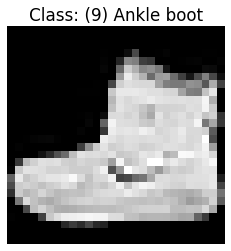

In [7]:
# Display example image
class_number = train_y[0]
class_name = class_names[class_number]
plt.imshow(train_x[0].reshape(28,28), cmap='gray')
plt.title('Class: (%d) %s' % (class_number, class_name))
plt.axis('off')

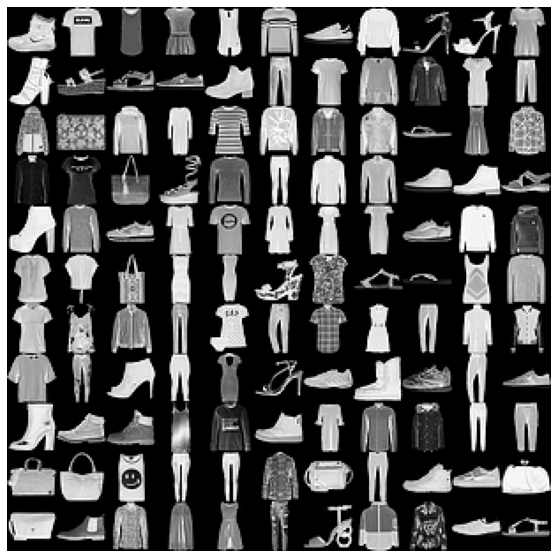

In [8]:
# figure with 11x11 images
n = 11 
img_size = 28
# Initialize Grid of Images for Figure
figure = np.zeros((img_size * n, img_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(0, 5, n)
grid_y = np.linspace(0, 5, n)

k = 0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        # Reshape and display example image
        img = train_x[k].reshape(28, 28) # i + j
        figure[i * img_size: (i + 1) * img_size,
               j * img_size: (j + 1) * img_size] = img
        k += 1

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.axis("off")
plt.show()

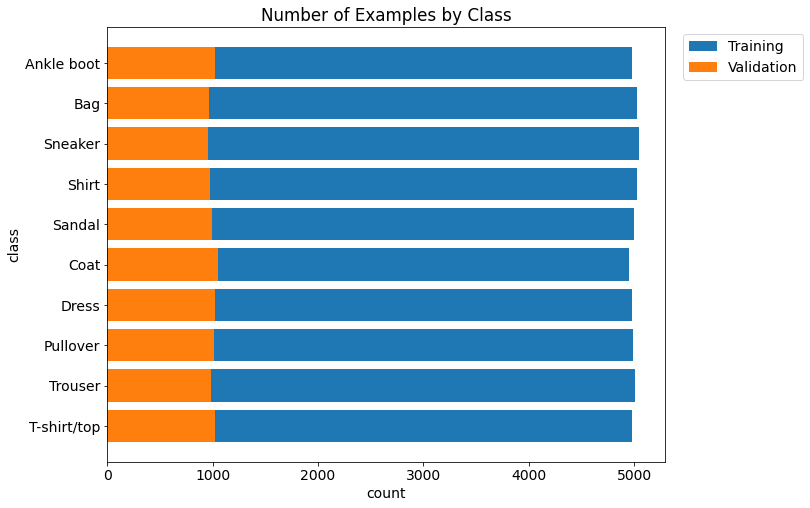

In [9]:
# Get the class labels and the corresponding counts
classes, class_counts = np.unique(train_y, return_counts=True)
classes_v, class_counts_v = np.unique(val_y, return_counts=True)

# Bar Plot
plt.figure(figsize=(10,8), )
plt.barh(class_names, class_counts, label='Training')

plt.barh(class_names, class_counts_v, label='Validation')
plt.title('Number of Examples by Class')
plt.xlabel('count')
plt.ylabel('class')

plt.legend(bbox_to_anchor=(1.02, 1))

### Building Traditional Autoencoder
Now that we know a bit about the dataset and the structure of models, let's build an autoencoder to create a compressed representation of our images.

In [10]:
# RESHAPE DATA INTO VECTOR FORMAT
# TODO: The pixels are now rearranged into a 1D vector instead of a 2D matrix
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)
test_x = test_x.reshape(-1, 784)

# Display data shape
train_x.shape, val_x.shape, test_x.shape

((50000, 784), (10000, 784), (10000, 784))

Reshaping 2D matrix to 1D vector

![reshape](https://drive.google.com/uc?id=1CRHDIrXE2lQlAs-ab5mupuvo3LLM1poR)

In [11]:
# TODO: Input placeholder
input_img = Input(shape=(784,), name='x')

# Encoded input representation
l1_out = Dense(2000, activation='relu', name='encoder_L1')(input_img)
l2_out = Dense(500, activation='relu', name='encoder_L2')(l1_out)
l3_out = Dense(500, activation='relu', name='encoder_L3')(l2_out)
latent = Dense(10, activation='sigmoid', name='z')(l3_out)

# Model maps input to an encoded representation
encoder = Model(input_img, latent)


# Lossy reconstruction of the input
l5_out = Dense(500, activation='relu', name='decoder_L1')(latent)
l6_out = Dense(500, activation='relu', name='decoder_L2')(l5_out)
l7_out = Dense(2000, activation='relu', name='decoder_L3')(l6_out)
recon = Dense(784, name='decoder_recon')(l7_out)


# FULL AE MODEL
# Model mapping input to its reconstruction
autoencoder = Model(input_img, recon)

# Display summary of model architecture
autoencoder.summary()

# Compile model, specifying training configuration (optimizer, loss, metrics, etc.)
autoencoder.compile(optimizer='adam', loss='mse')

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               [(None, 784)]             0         
_________________________________________________________________
encoder_L1 (Dense)           (None, 2000)              1570000   
_________________________________________________________________
encoder_L2 (Dense)           (None, 500)               1000500   
_________________________________________________________________
encoder_L3 (Dense)           (None, 500)               250500    
_________________________________________________________________
z (Dense)                    (None, 10)                5010      
_________________________________________________________________
decoder_L1 (Dense)           (None, 500)               5500      
_________________________________________________________________
decoder_L2 (Dense)           (None, 500)              

In [12]:
# Keras Callback for early stopping of training
estop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                                      patience=5, verbose=1, mode='auto')

# TODO: Train the model in "slices" or "batches"
# Repeatedly iterate over the entire dataset for a given number of "epochs"
t0 = time()
train_history = autoencoder.fit(train_x, train_x, epochs=10, batch_size=2048, 
                                validation_data=(val_x, val_x), callbacks=[estop])
t1 = time()
etime = (t1 - t0) / 60
print("Elapsed time: %.02f min" % etime)

Epoch 1/10
25/25 [==============================] - 27s 1s/step - loss: 0.0965 - val_loss: 0.0730
Epoch 2/10
25/25 [==============================] - 28s 1s/step - loss: 0.0659 - val_loss: 0.0553
Epoch 3/10
25/25 [==============================] - 28s 1s/step - loss: 0.0483 - val_loss: 0.0424
Epoch 4/10
25/25 [==============================] - 28s 1s/step - loss: 0.0400 - val_loss: 0.0380
Epoch 5/10
25/25 [==============================] - 27s 1s/step - loss: 0.0358 - val_loss: 0.0335
Epoch 6/10
25/25 [==============================] - 28s 1s/step - loss: 0.0330 - val_loss: 0.0314
Epoch 7/10
25/25 [==============================] - 28s 1s/step - loss: 0.0299 - val_loss: 0.0291
Epoch 8/10
25/25 [==============================] - 28s 1s/step - loss: 0.0269 - val_loss: 0.0255
Epoch 9/10
25/25 [==============================] - 28s 1s/step - loss: 0.0251 - val_loss: 0.0243
Epoch 10/10
25/25 [==============================] - 28s 1s/step - loss: 0.0238 - val_loss: 0.0234
Elapsed time: 4.83 

In [13]:
# Plot Learning Loss
def plot_learning_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel("Learning Epoch")
    plt.ylabel("Learning Loss")
    plt.legend()

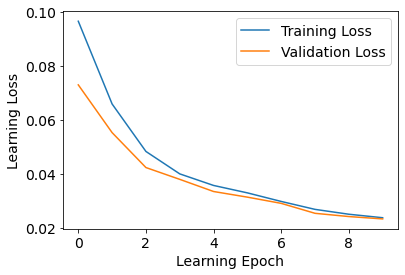

In [14]:
plot_learning_loss(train_history)

In [15]:
# RECONSTRUCTION
def plot_compare_reconstruction(ae, x):
    """
    PARAMS:
        ae: autoencoder
        x: example data set
    """
    # TODO: 'Predict' the reconstruction, using test set
    recon = ae.predict(x)

    # Compare original output to reconstructed
    plt.subplot(2, 2, 1)
    plt.imshow(recon[0].reshape(28,28), cmap='gray')
    plt.title('Reconstruction')
    plt.axis('off')
    plt.subplot(2, 2, 3)
    plt.imshow(recon[1].reshape(28,28), cmap='gray')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(x[0].reshape(28,28), cmap='gray')
    plt.title('Actual')
    plt.axis('off')
    plt.subplot(2, 2, 4)
    plt.imshow(x[1].reshape(28,28), cmap='gray')
    plt.axis('off')

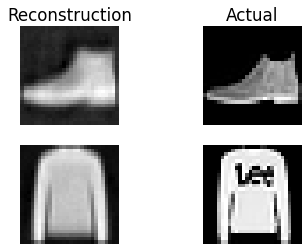

In [16]:
# RECONSTRUCTION
plot_compare_reconstruction(autoencoder, test_x)

#### Build Classifier Using Encoding

In [17]:
# TODO: Encode input
train_enc = encoder.predict(train_x)
val_enc = encoder.predict(val_x)
test_enc = encoder.predict(test_x)

train_enc.shape, val_enc.shape, test_enc.shape

((50000, 10), (10000, 10), (10000, 10))

In [18]:
# TODO: Input placeholder
input_enc = Input(shape=(10,), name='x')

# Encoded input representation
l2_out = Dense(500, activation='relu', name='classifier_L2')(input_enc)
l3_out = Dense(250, activation='relu', name='classifier_L3')(l2_out)
y = Dense(10, activation='sigmoid', name='z')(l3_out)

# Model maps input to classification
classifier = Model(input_enc, y)

# Display summary of model architecture
classifier.summary()

# Compile model
classifier.compile(optimizer='adam', 
                   loss=[keras.losses.SparseCategoricalCrossentropy()], 
                   metrics=[keras.metrics.SparseCategoricalAccuracy()])

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               [(None, 10)]              0         
_________________________________________________________________
classifier_L2 (Dense)        (None, 500)               5500      
_________________________________________________________________
classifier_L3 (Dense)        (None, 250)               125250    
_________________________________________________________________
z (Dense)                    (None, 10)                2510      
Total params: 133,260
Trainable params: 133,260
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
25/25 [==============================] - 2s 66ms/step - loss: 2.0720 - sparse_categorical_accuracy: 0.5331 - val_loss: 1.6757 - val_sparse_categorical_accuracy: 0.6349
Epoch 2/20
25/25 [==============================] - 1s 43ms/step - loss: 1.2352 - sparse_categorical_accuracy: 0.6786 - val_loss: 0.9215 - val_sparse_categorical_accuracy: 0.7050
Epoch 3/20
25/25 [==============================] - 1s 40ms/step - loss: 0.8325 - sparse_categorical_accuracy: 0.7109 - val_loss: 0.7630 - val_sparse_categorical_accuracy: 0.7243
Epoch 4/20
25/25 [==============================] - 1s 39ms/step - loss: 0.7438 - sparse_categorical_accuracy: 0.7224 - val_loss: 0.7239 - val_sparse_categorical_accuracy: 0.7324
Epoch 5/20
25/25 [==============================] - 1s 40ms/step - loss: 0.7150 - sparse_categorical_accuracy: 0.7299 - val_loss: 0.7060 - val_sparse_categorical_accuracy: 0.7351
Epoch 6/20
25/25 [==============================] - 1s 40ms/step - loss: 0.6977 - sparse_categorical_accu

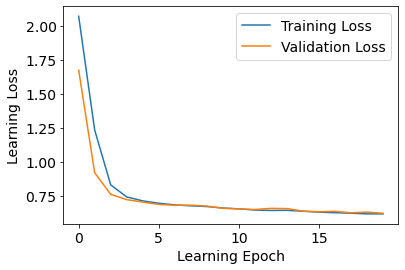

In [19]:
# Keras Callback for early stopping of training
estop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                                      patience=10, verbose=1, mode='auto')

# TODO: Train the model
t0 = time()
train_history = classifier.fit(train_enc, train_y, epochs=20, batch_size=2048, 
                                validation_data=(val_enc, val_y), callbacks=[estop])
t1 = time()
etime = (t1 - t0) / 60
print("Elapsed time: %.02f min" % etime)

# Get Learning Loss
plot_learning_loss(train_history)

In [20]:
# Evaluate classifier using test data
#test_encoding = encoder.predict(test_x)
test_loss, test_acc = classifier.evaluate(test_enc, test_y, batch_size=128) 

print("Test Loss: %.04f \nTest Accuracy: %.02f%%" % (test_loss, test_acc * 100))

79/79 [==============================] - 0s 2ms/step - loss: 0.6395 - sparse_categorical_accuracy: 0.7488
Test Loss: 0.6395 
Test Accuracy: 74.88%


#### Build Classifier Directly from Image Vector
Let's quickly compare and see the performance of a model trained using the encodings versuses the performance of a model trained using all the pixels 

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               [(None, 784)]             0         
_________________________________________________________________
classifier_L2 (Dense)        (None, 500)               392500    
_________________________________________________________________
classifier_L3 (Dense)        (None, 250)               125250    
_________________________________________________________________
z (Dense)                    (None, 10)                2510      
Total params: 520,260
Trainable params: 520,260
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
25/25 [==============================] - 3s 109ms/step - loss: 1.0266 - sparse_categorical_accuracy: 0.6815 - val_loss: 0.5990 - val_sparse_categorical_accuracy: 0.7850
Epoch 2/10
25/25 [==============================] - 3s 105ms/step 

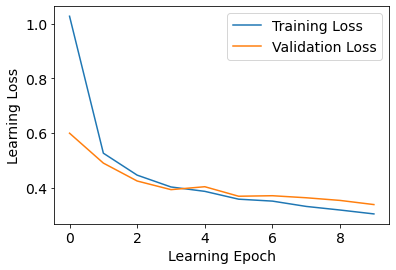

In [21]:
# Input placeholder
input_x = Input(shape=(784,), name='x')

# Encoded input representation
l2_out = Dense(500, activation='relu', name='classifier_L2')(input_x)
l3_out = Dense(250, activation='relu', name='classifier_L3')(l2_out)
y = Dense(10, activation='sigmoid', name='z')(l3_out)

# Model maps input to classification
img_classifier = Model(input_x, y)

# Display summary of model architecture
img_classifier.summary()

# Compile model
img_classifier.compile(optimizer='adam', 
                   loss=[keras.losses.SparseCategoricalCrossentropy()], 
                   metrics=[keras.metrics.SparseCategoricalAccuracy()])

# Keras Callback for early stopping of training
estop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                                      patience=5, verbose=1, mode='auto')

# Train the model
t0 = time()
train_history = img_classifier.fit(train_x, train_y, epochs=10, batch_size=2048, 
                                validation_data=(val_x, val_y), callbacks=[estop])
t1 = time()
etime = (t1 - t0) / 60
print("Elapsed time: %.02f min" % etime)

# Plot Learning Loss
plot_learning_loss(train_history)

In [22]:
# Evaluate classifier using test data
test_loss, test_acc = img_classifier.evaluate(test_x, test_y, batch_size=128)
print("Test Loss: %.04f \nTest Accuracy: %.02f%%" % (test_loss, test_acc * 100))

79/79 [==============================] - 0s 6ms/step - loss: 0.3641 - sparse_categorical_accuracy: 0.8745
Test Loss: 0.3641 
Test Accuracy: 87.45%


### Sparse Autoencoder
Optimize compressed output by reducing the amount of memory using sparse representations instead 

To make representations more compact, impose a sparsity constraint on the activition of the hidden representations (this is the activity 
regularizer in Keras), such that fewer units get activated at a given time

In Keras we use the "activity_regularizer" parameter for each layer to apply penalties on parameters or activations during optimization. 
Penalties are incorporated in the loss function

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               [(None, 784)]             0         
_________________________________________________________________
encoder_L1 (Dense)           (None, 2000)              1570000   
_________________________________________________________________
encoder_L2 (Dense)           (None, 500)               1000500   
_________________________________________________________________
encoder_L3 (Dense)           (None, 500)               250500    
_________________________________________________________________
z (Dense)                    (None, 10)                5010      
_________________________________________________________________
decoder_L1 (Dense)           (None, 500)               5500      
_________________________________________________________________
decoder_L2 (Dense)           (None, 500)             

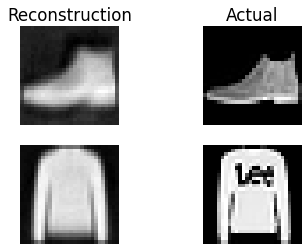

In [23]:
# Load existing model
sparse_ae = tf.keras.models.load_model('saved_models/sparse_autoencoder')
sparse_ae.summary()
plot_compare_reconstruction(sparse_ae, test_x)

In [24]:
# Include activity constraint by defining a small value for the activity_regularizer
# ref (https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer)

# Input placeholder
input_img = Input(shape=(784,), name='x')

# TODO: Encoded input representation
l1_out = Dense(2000, activation='relu', name='encoder_L1')(input_img)
l2_out = Dense(500, activation='relu', name='encoder_L2',
               activity_regularizer=regularizers.l1(10e-10))(l1_out)
l3_out = Dense(500, activation='relu', name='encoder_L3',
               activity_regularizer=regularizers.l1(10e-10))(l2_out)
latent = Dense(10, activation='sigmoid', name='z',
               activity_regularizer=regularizers.l1(10e-10))(l3_out)

# Model maps input to an encoded representation
sparse_encoder = Model(input_img, latent)


# Lossy reconstruction of the input
l5_out = Dense(500, activation='relu', name='decoder_L1')(latent)
l6_out = Dense(500, activation='relu', name='decoder_L2')(l5_out)
l7_out = Dense(2000, activation='relu', name='decoder_L3')(l6_out)
sparse_recon = Dense(784, name='sparse_recon')(l7_out)

# Model mapping latent representation to input reconstruction
#sparse_decoder = Model(encoded, decoded)

# Model mapping input to its reconstruction
sparse_autoencoder = Model(input_img, sparse_recon)

# Display summary of model architecture
sparse_autoencoder.summary()

# Compile model
sparse_autoencoder.compile(optimizer='adam', loss='mse')

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               [(None, 784)]             0         
_________________________________________________________________
encoder_L1 (Dense)           (None, 2000)              1570000   
_________________________________________________________________
encoder_L2 (Dense)           (None, 500)               1000500   
_________________________________________________________________
encoder_L3 (Dense)           (None, 500)               250500    
_________________________________________________________________
z (Dense)                    (None, 10)                5010      
_________________________________________________________________
decoder_L1 (Dense)           (None, 500)               5500      
_________________________________________________________________
decoder_L2 (Dense)           (None, 500)             

Epoch 1/10
25/25 [==============================] - 28s 1s/step - loss: 0.0941 - val_loss: 0.0711
Epoch 2/10
25/25 [==============================] - 28s 1s/step - loss: 0.0626 - val_loss: 0.0520
Epoch 3/10
25/25 [==============================] - 28s 1s/step - loss: 0.0453 - val_loss: 0.0407
Epoch 4/10
25/25 [==============================] - 28s 1s/step - loss: 0.0383 - val_loss: 0.0388
Epoch 5/10
25/25 [==============================] - 28s 1s/step - loss: 0.0348 - val_loss: 0.0329
Epoch 6/10
25/25 [==============================] - 28s 1s/step - loss: 0.0319 - val_loss: 0.0307
Epoch 7/10
25/25 [==============================] - 28s 1s/step - loss: 0.0295 - val_loss: 0.0290
Epoch 8/10
25/25 [==============================] - 28s 1s/step - loss: 0.0269 - val_loss: 0.0258
Epoch 9/10
25/25 [==============================] - 28s 1s/step - loss: 0.0254 - val_loss: 0.0247
Epoch 10/10
25/25 [==============================] - 28s 1s/step - loss: 0.0240 - val_loss: 0.0236
Elapsed Time: 4.87 

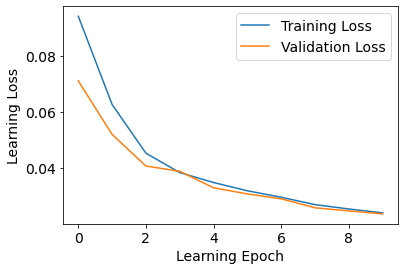

In [25]:
# Train the model
t0 = time()
train_history = sparse_autoencoder.fit(train_x, train_x, 
                                       epochs=10, 
                                       batch_size=2048,
                                       validation_data=(val_x, val_x))
t1 = time()
duration = (t1 - t0) / 60 # convert to minutes
print('Elapsed Time: %.02f min' % duration)

# Save the entire model
sparse_autoencoder.save('saved_models/sparse_autoencoder') 

# Plot Learning Loss
plot_learning_loss(train_history)

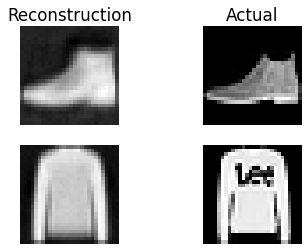

In [26]:
plot_compare_reconstruction(sparse_autoencoder, test_x)

### Denoising AutoEncoders
When an image gets corrupted, or contains noise, there is no straight-forward way to remove the noise. 

We want to "denoise" the image and convert the noisy image into a somewhat clearer image with most (or all) of the noise removed.

Example from a simple model:

![Denoising](https://drive.google.com/uc?id=12W8w9c-CtUIl7UeWRmFrY5E9Cw1qD_pk)

In [27]:
# Load existing model
denoise_ae = tf.keras.models.load_model('saved_models/denoise_autoencoder')
denoise_ae.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_L1_conv2d (Conv2D)   (None, 28, 28, 64)        640       
_________________________________________________________________
encoder_L1_max (MaxPooling2D (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_L2_conv2d (Conv2D)   (None, 14, 14, 32)        18464     
_________________________________________________________________
encoder_L2_max (MaxPooling2D (None, 7, 7, 32)          0         
_________________________________________________________________
encoder_L3_conv2d (Conv2D)   (None, 7, 7, 16)          4624      
_________________________________________________________________
encoder_L3_max (MaxPooling2D (None, 4, 4, 16)        

#### Convolutional Neural Network (CNN)

Similar structure to a standard neural network
1. Input layer
2. Some number of hidden layers
    * convolution 
    * max or mean pooling 
    * activation function
    * fully connected dense layers
3. Output layer

![CNN](https://adeshpande3.github.io/assets/Cover.png)

![CNN gif](https://miro.medium.com/max/2340/1*Fw-ehcNBR9byHtho-Rxbtw.gif)

In [28]:
# LOAD DATA
(training_x, training_y), (testing_x, testing_y) = fashion_mnist.load_data()

# Introduce noise to some of the data
# NOTE: In reality we don't know the source or structure of the noise
seq = iaa.Sequential([iaa.SaltAndPepper(.2)])

training_x_aug = seq.augment_images(training_x)
test_x_aug = seq.augment_images(testing_x)

# Split Training Data into Training and Validation
train_size = 50000
train_x_aug = training_x_aug[:train_size]
val_x_aug = training_x_aug[train_size:]

# Clean data
train_x = training_x[:train_size]
train_y = training_y[:train_size]
val_x = training_x[train_size:]
val_y = training_y[train_size:]

In [29]:
# PRE_PROCESS THE DATA
train_x_aug = train_x_aug / 255.
val_x_aug = val_x_aug / 255.
test_x_aug = test_x_aug / 255.

train_x = train_x / 255.
val_x = val_x / 255.
test_x = testing_x / 255.

# RESHAPE INTO TENSORS FOR CNN
train_x_aug_img = train_x_aug.reshape(-1, 28, 28, 1)
val_x_aug_img = val_x_aug.reshape(-1, 28, 28, 1)
test_x_aug_img = test_x_aug.reshape(-1, 28, 28, 1)

train_x_img = train_x.reshape(-1, 28, 28, 1) # TODO
val_x_img = val_x.reshape(-1, 28, 28, 1)
test_x_img = test_x.reshape(-1, 28, 28, 1)

train_x_img.shape, val_x_img.shape, test_x_img.shape

((50000, 28, 28, 1), (10000, 28, 28, 1), (10000, 28, 28, 1))

In [30]:
# TODO: Input placeholder
input_img = Input(shape=(28, 28, 1))

# Encoded input representation
# padding=same: zero padding during convolution and pooling
# padding=valid: no padding during convolution and pooling
l1_out = Conv2D(64, (3, 3), activation='relu', padding='same', 
                name='encoder_L1_conv2d')(input_img)
l1_out = MaxPool2D((2, 2), padding='same', name='encoder_L1_max')(l1_out)

l2_out = Conv2D(32, (3, 3), activation='relu', padding='same', 
                name='encoder_L2_conv2d')(l1_out)
l2_out = MaxPool2D((2, 2), padding='same', name='encoder_L2_max')(l2_out)

l3_out = Conv2D(16, (3, 3), activation='relu', padding='same', 
                name='encoder_L3_conv2d')(l2_out)
l3_out = MaxPool2D((2, 2), padding='same', name='encoder_L3_max')(l3_out)

# Model mapping input to its encoded representation
denoise_encoder = Model(input_img, l3_out)


# Lossy reconstruction of the input
l4_out = Conv2D(16, (3, 3), activation='relu', padding='same',
                name='decoder_L1_conv2d')(l3_out)
l4_out = UpSampling2D((2, 2), name='decoder_L1_up')(l4_out)

l5_out = Conv2D(32, (3, 3), activation='relu', padding='same',
                name='decoder_L2_conv2d')(l4_out)
l5_out = UpSampling2D((2, 2), name='decoder_L2_up')(l5_out)

l6_out = Conv2D(64, (3, 3), activation='relu',
                name='decoder_L3_conv2d')(l5_out)
l6_out = UpSampling2D((2, 2), name='decoder_L3_up')(l6_out)

recon = Conv2D(1, (3, 3), padding='same', name='decoder_recon')(l6_out)


# FULL AUTOENCODER
# Model mapping input to its reconstruction
denoise_autoencoder = Model(input_img, recon)

# Display Summary
denoise_autoencoder.summary()

# Compile model
denoise_autoencoder.compile(optimizer='adam', loss='mse')

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_L1_conv2d (Conv2D)   (None, 28, 28, 64)        640       
_________________________________________________________________
encoder_L1_max (MaxPooling2D (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_L2_conv2d (Conv2D)   (None, 14, 14, 32)        18464     
_________________________________________________________________
encoder_L2_max (MaxPooling2D (None, 7, 7, 32)          0         
_________________________________________________________________
encoder_L3_conv2d (Conv2D)   (None, 7, 7, 16)          4624      
_________________________________________________________________
encoder_L3_max (MaxPooling2D (None, 4, 4, 16)        

Epoch 1/10
20/20 [==============================] - 88s 4s/step - loss: 0.1106 - val_loss: 0.0712
Epoch 2/10
20/20 [==============================] - 88s 4s/step - loss: 0.0538 - val_loss: 0.0428
Epoch 3/10
20/20 [==============================] - 89s 4s/step - loss: 0.0387 - val_loss: 0.0354
Epoch 4/10
20/20 [==============================] - 88s 4s/step - loss: 0.0331 - val_loss: 0.0309
Epoch 5/10
20/20 [==============================] - 87s 4s/step - loss: 0.0293 - val_loss: 0.0278
Epoch 6/10
20/20 [==============================] - 89s 4s/step - loss: 0.0268 - val_loss: 0.0261
Epoch 7/10
20/20 [==============================] - 89s 4s/step - loss: 0.0252 - val_loss: 0.0247
Epoch 8/10
20/20 [==============================] - 90s 4s/step - loss: 0.0242 - val_loss: 0.0236
Epoch 9/10
20/20 [==============================] - 90s 4s/step - loss: 0.0233 - val_loss: 0.0229
Epoch 10/10
20/20 [==============================] - 89s 4s/step - loss: 0.0225 - val_loss: 0.0223
Elapsed time: 15.52

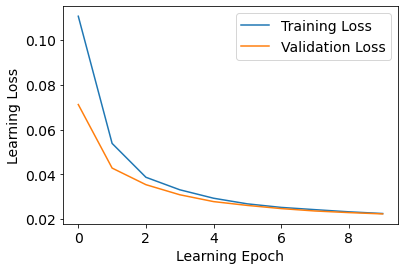

In [31]:
# Train the model
# NOTE: Noisy image is the input; try to reconstruct the original denoised image
# Select subset of data to speed up learning
x_in = train_x_aug_img[:20000]
x_out = train_x_img[:20000]
val_x_in = val_x_aug_img[:5000]
val_x_out = val_x_img[:5000]

t0 = time()
train_history = denoise_autoencoder.fit(x_in, x_out, epochs=10, batch_size=1024,
                                        validation_data=(val_x_aug_img, val_x_img))
t1 = time()
etime = (t1 - t0) / 60
print("Elapsed time: %.02f" % etime)

# Save the entire model
denoise_autoencoder.save('saved_models/denoise_autoencoder') 

# Plot Learning Loss
plot_learning_loss(train_history)

(-0.5, 27.5, 27.5, -0.5)

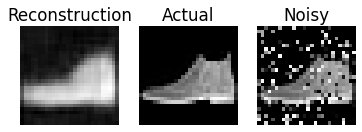

In [32]:
# RECONSTRUCTION
denoised_x = denoise_autoencoder.predict(test_x_aug_img)

# Compare reconstruction to the original input and the noisy input
plt.subplot(1, 3, 1)
plt.imshow(denoised_x[0].reshape(28, 28), cmap='gray')
plt.title('Reconstruction')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(test_x[0].reshape(28, 28), cmap='gray')
plt.title('Actual')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(test_x_aug[0].reshape(28, 28), cmap='gray')
plt.title('Noisy')
plt.axis('off')

### [Variational AutoEncoders (VAE)](https://www.jeremyjordan.me/variational-autoencoders/)
Image Generation with Variational AutoEncoders

Main distinction between traditional autoencoders and variational autoencoders is that instead of a compressed bottleneck of information, we attempt to model th probability distribution of the training 
data. 

Generally, from the mean and standard deviation of the data, we can approximate the properties of the population. (Note: the modeled central tendency does not have to be the mean, and the spread does not have to be the standard deviation)

VAEs learn stochastic/probabilitic mappings between the input space and latent space

In this tutorial, the population represents all images that can be in the category of class of training data.

Latent Space: if assumed to have Gaussian distribution, it's parameters are mean, and standard deviation
[](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/08/Line-Plot-of-Events-vs-Probability-or-the-Probability-Density-Function-for-the-Normal-Distribution.png)
![](https://miro.medium.com/max/2900/1*knCUJJjFHW92ec8d8iq4kQ.png)

![VAE](https://drive.google.com/uc?id=1HdsZ-0xL7iBBLNbchJk8xb9S8PhSqQI8)

![VAE](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/06/1_Y49K5UhSMzB3TcA2FKzPMQ.png)

Variational Autoencoder loss considers two things:
1. The negative log likelihood of the output $x_i$ multipled by their corresponding weight (or probability) $p_i$<br>
$$-E_{z \approx q_\theta(z|x_i)} [log (p_\phi (x_i|z))]$$  
> $E[X]=\sum_{i=1}^{n}{x_i p_i}$ expectation (i.e. expected or average value) is the weighted sum of all examples  
$q_\theta(z|x_i)$ Learned latent space distribution  
$p_\phi (x_i|z)$ Distribution of x given z (reconstruction distribution)  

2. Kullback-Leibler Divergence (KLD) of the "actual" (i.e. the prior) distribution and the predicted distribution. 
    * KLD metric describing difference between two distributions
    * Ideally the difference between the true distribution and the modeled distribution should as small as possible
    $$KL(q_\phi (z|x_i) || p(z)) = q_\phi (z|x_i) * log(\frac{q_\phi (z|x_i)}{p(z)})$$

Combining parts (1) and (2) to construct our loss function:
$$loss = l_i(\theta, \phi)=-E_{z \approx q_\theta(z|x_i)} [log (p_\phi (x_i|z))] + KL(q_\phi (z|x_i) || p(z))$$

In [33]:
# LOAD DATA
(training_x, training_y), (testing_x, testing_y) = fashion_mnist.load_data()
training_x.shape, training_y.shape, testing_x.shape, testing_y.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [34]:
# SPLIT TRAINING SET
train_size = 50000
train_x = training_x[:train_size]
train_y = training_y[:train_size]
val_x = training_x[train_size:]
val_y = training_y[train_size:]

# PRE-PROCESS DATA
train_x = train_x / 255.
val_x = val_x / 255.
test_x = testing_x / 255.

# VECTORIZE DATA
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)
test_x = test_x.reshape(-1, 784)

train_x.shape, val_x.shape, test_x.shape

((50000, 784), (10000, 784), (10000, 784))

In [35]:
# TODO: Input placeholder
input_img = Input(shape=(784,))

# Encoded input representation
l1_out = Dense(500, activation='relu', name='encoder_L1')(input_img)
z_mu = Dense(10, name='z_mu')(l1_out)
z_log_sigma = Dense(10, name='z_log_sigma')(l1_out)


# Define layer to incorporate KL divergence into the training loss
class KLDLayer(Layer):
    """
    Layer designed to incorporate the loss associated with the 
    latent space distribution
    """
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDLayer, self).__init__(*args, **kwargs)
    def call(self, inputs):
        mu, log_sigma = inputs
        kl_batch = -.5 * K.sum(1 + log_sigma -
                               K.square(mu) - 
                               K.exp(log_sigma), axis=-1)
        kl_loss = K.mean(kl_batch)
        self.add_loss(kl_loss, inputs=inputs)
        return inputs

# Define function for sampling in the latent space
def sampling(args):
    """
    PARAMS:
        args = (z_mean, z_log_var)
            z_mean (tensor): mean of the latent space
            z_log_var (tensor): log of the variance of the latent space
    RETURN:
        z (tensor): a sample from the latent space
    """
    z_mu, z_log_var = args
    batch_size = K.shape(z_mu)[0]
    latent_dim = K.int_shape(z_mu)[1]
    epsilon = K.random_normal(shape=(batch_size, latent_dim))
    return z_mu + K.exp(.5 * z_log_var) * epsilon


# Create the KLD layer for the model
z_mu, z_log_sigma = KLDLayer()([z_mu, z_log_sigma])

# Sample from the latent space distribution
z = Lambda(sampling, output_shape=(10,))([z_mu, z_log_sigma])

# Model mapping to input representation (i.e. the encoder)
v_encoder = Model(input_img, z)


# Model mapping input to its reconstruction
v_decoder = Sequential([
                        Dense(500, input_dim=10, activation='relu', name='decoder_L1'),
                        Dense(784, activation='sigmoid', name='decoder_recon')
])
recon = v_decoder(z)


# Model mapping an input to its reconstruction
vae = Model(input_img, recon)

# Display model summary
vae.summary()

# Function to compute the negative log likelihood
def nll(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

# Compile model
vae.compile(optimizer='adam', loss=nll)

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder_L1 (Dense)              (None, 500)          392500      input_2[0][0]                    
__________________________________________________________________________________________________
z_mu (Dense)                    (None, 10)           5010        encoder_L1[0][0]                 
__________________________________________________________________________________________________
z_log_sigma (Dense)             (None, 10)           5010        encoder_L1[0][0]                 
______________________________________________________________________________________

Epoch 1/20
25/25 [==============================] - 5s 199ms/step - loss: 439.4274 - val_loss: 356.1098
Epoch 2/20
25/25 [==============================] - 5s 195ms/step - loss: 327.6814 - val_loss: 308.6799
Epoch 3/20
25/25 [==============================] - 5s 194ms/step - loss: 298.2952 - val_loss: 289.9776
Epoch 4/20
25/25 [==============================] - 5s 195ms/step - loss: 283.7543 - val_loss: 280.7879
Epoch 5/20
25/25 [==============================] - 5s 193ms/step - loss: 275.5267 - val_loss: 273.4336
Epoch 6/20
25/25 [==============================] - 5s 193ms/step - loss: 270.1948 - val_loss: 269.2240
Epoch 7/20
25/25 [==============================] - 5s 193ms/step - loss: 266.6684 - val_loss: 267.5052
Epoch 8/20
25/25 [==============================] - 5s 201ms/step - loss: 264.2265 - val_loss: 264.5244
Epoch 9/20
25/25 [==============================] - 5s 205ms/step - loss: 262.0324 - val_loss: 262.0359
Epoch 10/20
25/25 [==============================] - 5s 206ms/st

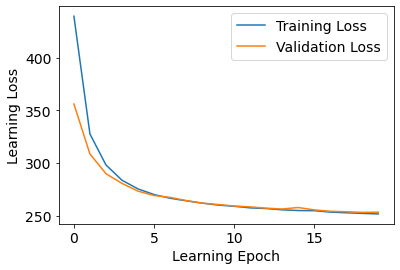

In [36]:
# Train the model to generate images
t0 = time()
train_history = vae.fit(train_x, train_x, epochs=20, batch_size=2048, 
                        validation_data=(val_x, val_x))
t1 = time()
etime = float(t1 - t0) / 60
print("Elapsed time: %.02f min" % etime)

# Plot Learning Loss
plot_learning_loss(train_history)

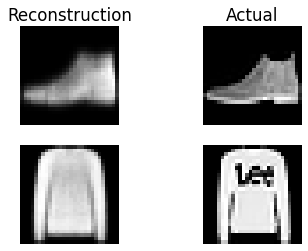

In [37]:
# RECONSTRUCTION
plot_compare_reconstruction(vae, test_x)

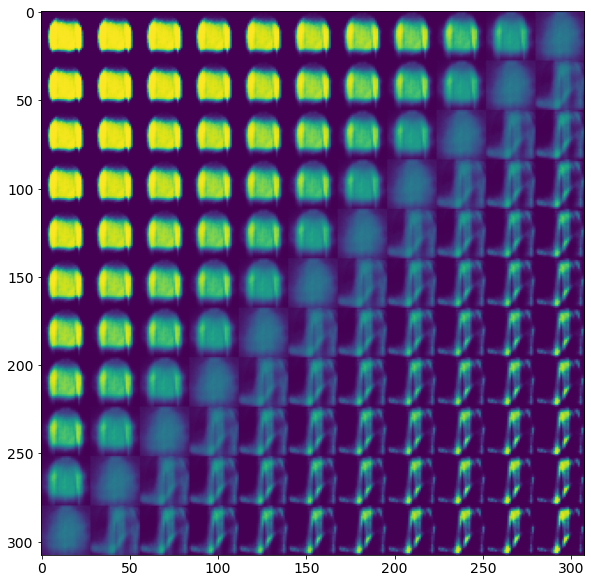

In [38]:
# GENERATION AND LINEAR INTERPOLATION IN THE LATENT SPACE
n = 11  # figure with 11x11 imgs
img_size = 28
figure = np.zeros((img_size * n, img_size * n))
# we will sample n points within [-11, 11] standard deviations
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.repeat(np.array([[xi + yi]]), 10, axis=1)
        x_decoded = v_decoder.predict(z_sample)
        img = x_decoded[0].reshape(img_size, img_size)
        figure[i * img_size: (i + 1) * img_size,
               j * img_size: (j + 1) * img_size] = img

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

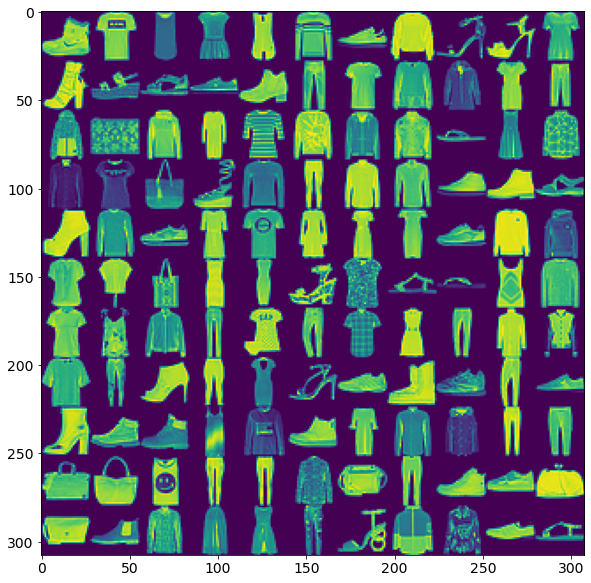

In [39]:
# DISPLAY IMAGES
n = 11  # figure with 11x11 imgs
img_size = 28
figure = np.zeros((img_size * n, img_size * n))
# we will sample n points within [-11, 11] standard deviations
grid_x = np.linspace(0, 5, n)
grid_y = np.linspace(0, 5, n)

k = 0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        # Display example image
        img = train_x[k].reshape(28,28) # i + j
        #plt.title('Class: %d' % train_y[0])
        figure[i * img_size: (i + 1) * img_size,
               j * img_size: (j + 1) * img_size] = img
        k += 1

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [40]:
gt1 = time()
g_etime = (gt1 - gt0) / 60
print("Global Elapsed Time: %.02f min" % g_etime)

Global Elapsed Time: 29.92 min


# Closing

<center>  
<h1>QUESTIONS?</h1>

<h1>THANK YOU</h1>

<a href="https://ousurvey.qualtrics.com/jfe/form/SV_0On07oFsn378Kzz">Post-knowledge Survey</a>

If you went through the tutorial please complete this brief [sign in form](https://forms.office.com/Pages/ResponsePage.aspx?id=neB9nDSQwUS0YsRk_s4gShSiFd0SB9NPmtonqJ4UHH1UMVBTS1BDOElEMkM1U09FSE9HMzM0Rkw4TiQlQCN0PWcu)

Facebook 
[@oucsgsa](https://www.facebook.com/oucsgsa/?ref=page_internal)

![fb_tag](https://drive.google.com/uc?id=13Ph4OnbDWNqd1nXoSfCykCSQXVy_SEIm)

Instagram

![insta_tag](https://drive.google.com/uc?id=1_ZXNZMqEyB-LfDLnhVTeiS1-2ywih4BR)
</center>